In [18]:
from hnn_core import simulate_dipole, calcium_model, MPIBackend, read_params, jones_2009_model
import os.path as op
import hnn_core
from hnn_core.viz import plot_dipole
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from utils import add_supra_beta_drives, rescale_pyr_morph
sns.set()
sns.set_style("whitegrid")


In [19]:
def law_2021_model():
    """Instantiate the beta modulated ERP network model.
    Returns
    -------
    net : Instance of Network object
        Network object used to store the model used in
        Law et al. 2021.
    See Also
    --------
    jones_2009_model
    Notes
    -----
    Model reproduces results from Law et al. 2021
    This model differs from the default network model in several
    parameters including
    1) Increased GABAb time constants on L2/L5 pyramidal cells
    2) Decrease L5_pyramidal -> L5_pyramidal nmda weight
    3) Modified L5_basket -> L5_pyramidal inhibition weights
    4) Removal of L5 pyramidal somatic and basal dendrite calcium channels
    5) Replace L2_basket -> L5_pyramidal GABAa connection with GABAb
    6) Addition of L5_basket -> L5_pyramidal distal connection
    """

    hnn_core_root = op.dirname(hnn_core.__file__)
    params_fname = op.join(hnn_core_root, 'param', 'default.json')
    params = read_params(params_fname)

    net = jones_2009_model(params)

    # Update biophysics (increase gabab duration of inhibition)
    net.cell_types['L2_pyramidal'].synapses['gabab']['tau1'] = 45.0
    net.cell_types['L2_pyramidal'].synapses['gabab']['tau2'] = 200.0
    net.cell_types['L5_pyramidal'].synapses['gabab']['tau1'] = 45.0
    net.cell_types['L5_pyramidal'].synapses['gabab']['tau2'] = 200.0

    # Decrease L5_pyramidal -> L5_pyramidal nmda weight
    net.connectivity[2]['nc_dict']['A_weight'] = 0.0004

    # Modify L5_basket -> L5_pyramidal inhibition
    net.connectivity[6]['nc_dict']['A_weight'] = 0.02  # gabaa
    net.connectivity[7]['nc_dict']['A_weight'] = 0.005  # gabab

    # Remove L5 pyramidal somatic and basal dendrite calcium channels
    for sec in ['soma', 'basal_1', 'basal_2', 'basal_3']:
        del net.cell_types['L5_pyramidal'].sections[
            sec].mechs['ca']

    # Remove L2_basket -> L5_pyramidal gabaa connection
    del net.connectivity[10]  # Original paper simply sets gbar to 0.0

    # Add L2_basket -> L5_pyramidal gabab connection
    delay = net.delay
    src_cell = 'L2_basket'
    target_cell = 'L5_pyramidal'
    lamtha = 50.
    weight = 0.00005
    loc = 'distal'
    receptor = 'gabab'
    net.add_connection(
        src_cell, target_cell, loc, receptor, weight, delay, lamtha)

    # Add L5_basket -> L5_pyramidal distal connection
    # ("Martinotti-like recurrent tuft connection")
    src_cell = 'L5_basket'
    target_cell = 'L5_pyramidal'
    lamtha = 70.
    loc = 'distal'
    receptor = 'gabaa'
    key = f'gbar_L5Basket_L5Pyr_{receptor}'
    weight = net._params[key]
    net.add_connection(
        src_cell, target_cell, loc, receptor, weight, delay, lamtha)

    return net

In [20]:
def add_law_beta_drives(net, beta_start, l2inh_prob=1.0, l5inh_prob=1.0, l2inh_strength=2.0, l5inh_strength=1.0):
    # Distal Drive
    weights_ampa_d1 = {'L2_basket': 0.00032, 'L2_pyramidal': 0.00008,
                       'L5_pyramidal': 0.00004}
    syn_delays_d1 = {'L2_basket': 0.5, 'L2_pyramidal': 0.5,
                     'L5_pyramidal': 0.5}
    conn_prob_d1 = {'L2_basket': 1.0, 'L2_pyramidal': 1.0,
                    'L5_pyramidal': 1.0}
    net.add_bursty_drive(
        'Distal Drive', tstart=beta_start, tstart_std=0., tstop=beta_start + 50.,
        burst_rate=1., burst_std=5., numspikes=2, spike_isi=10, n_drive_cells=10,
        location='distal', weights_ampa=weights_ampa_d1,
        synaptic_delays=syn_delays_d1, event_seed=10, probability=conn_prob_d1)

    # Proximal Drive
    weights_ampa_p1 = {'L2_basket': 0.00004 * l2inh_strength, 'L2_pyramidal': 0.00002,
                       'L5_basket': 0.00002 * l5inh_strength, 'L5_pyramidal': 0.00002}
    syn_delays_p1 = {'L2_basket': 0.1, 'L2_pyramidal': 0.1,
                     'L5_basket': 1.0, 'L5_pyramidal': 1.0}
    conn_prob_p1 = {'L2_basket': l2inh_prob, 'L2_pyramidal': 1.0,
                     'L5_basket': l5inh_prob, 'L5_pyramidal': 1.0}

    net.add_bursty_drive(
        'Proximal Drive', tstart=beta_start, tstart_std=0., tstop=beta_start + 50.,
        burst_rate=1., burst_std=30., numspikes=2, spike_isi=10, n_drive_cells=10,
        location='proximal', weights_ampa=weights_ampa_p1,
        synaptic_delays=syn_delays_p1, event_seed=10, probability=conn_prob_p1)

    return net

In [21]:
net_orig = law_2021_model()

l5_prob_sweep = [0.02, 1.0]
dpl_L5IN_list = list()
net_L5IN_list = list()

for prob in l5_prob_sweep:

    net = net_orig.copy()
    add_law_beta_drives(net, beta_start=200.0, l5inh_prob=prob, l2inh_prob=1.0, l2inh_strength=0.0, l5inh_strength=100.0)

    with MPIBackend(n_procs=8):
        dpl = simulate_dipole(net, tstop=500, dt=0.05, record_isoma=True)[0]

    dpl_L5IN_list.append(dpl)
    net_L5IN_list.append(net)

MPI will run over 8 processes
Running 1 trials...
numprocs=8
Loading custom mechanism files from /home/ntolley/Jones_Lab/hnn-core/hnn_core/mod/x86_64/.libs/libnrnmech.so
Building the NEURON model
Loading custom mechanism files from /home/ntolley/Jones_Lab/hnn-core/hnn_core/mod/x86_64/.libs/libnrnmech.so
Loading custom mechanism files from /home/ntolley/Jones_Lab/hnn-core/hnn_core/mod/x86_64/.libs/libnrnmech.so
Loading custom mechanism files from /home/ntolley/Jones_Lab/hnn-core/hnn_core/mod/x86_64/.libs/libnrnmech.so
Loading custom mechanism files from /home/ntolley/Jones_Lab/hnn-core/hnn_core/mod/x86_64/.libs/libnrnmech.so
Loading custom mechanism files from /home/ntolley/Jones_Lab/hnn-core/hnn_core/mod/x86_64/.libs/libnrnmech.so
Loading custom mechanism files from /home/ntolley/Jones_Lab/hnn-core/hnn_core/mod/x86_64/.libs/libnrnmech.so
Loading custom mechanism files from /home/ntolley/Jones_Lab/hnn-core/hnn_core/mod/x86_64/.libs/libnrnmech.so
[Done]
running trial 1 on 8 cores
Simulat

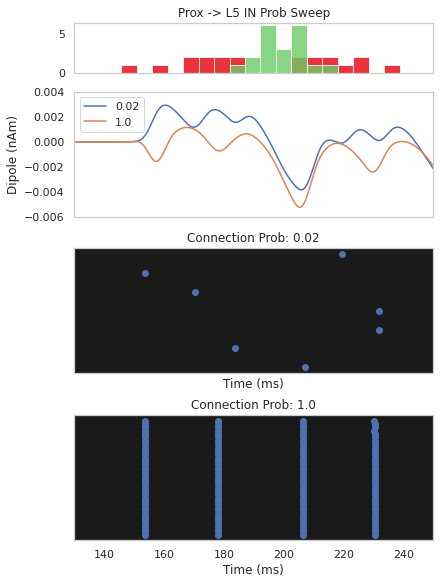

In [22]:
fig, axes = plt.subplots(4, 1, sharex=True, figsize=(6, 8), constrained_layout=True, 
                         gridspec_kw={'height_ratios': [0.4, 1 , 1, 1]})
freqs = np.arange(8, 50)
times = dpl_L5IN_list[0].times
for plot_idx, (plt_dpl, prob, net) in enumerate(zip(dpl_L5IN_list, l5_prob_sweep, net_L5IN_list)):
    dpl_smooth = plt_dpl.copy().smooth(10).data['agg']
    axes[1].plot(times, dpl_smooth, label=f'{prob}')
    axes[plot_idx+2].set_title(f'Connection Prob: {prob}')
    net.copy().cell_response.plot_spikes_raster(ax=axes[plot_idx+2], show=False)
    axes[plot_idx].set_xlabel('')

p_mask = np.array(net_L5IN_list[0].cell_response.spike_types[0]) == 'Proximal Drive'
d_mask = np.array(net_L5IN_list[0].cell_response.spike_types[0]) == 'Distal Drive'
p_times = np.array(net_L5IN_list[0].cell_response.spike_times[0])[p_mask]
d_times = np.array(net_L5IN_list[0].cell_response.spike_times[0])[d_mask]
bins = np.linspace(125, 275, 30)
axes[0].hist(p_times, color="#E8000B", label='Proximal', alpha=0.8, bins=bins)
axes[0].hist(d_times, color="#6ACC65", label='Distal', alpha=0.8, bins=bins)

axes[0].set_title('Prox -> L5 IN Prob Sweep')
axes[1].set_ylim([-0.006, 0.004])
axes[3].set_xlabel('Time (ms)')
axes[1].set_ylabel('Dipole (nAm)')
axes[1].legend()
axes[2].get_legend().remove()
axes[3].get_legend().remove()

for ax in axes:
    ax.grid(False)

plt.xlim([130,250])
plt.savefig('u19_page2_figures/law_input_prox_dist_l5inh_prob_sweep_spikes.png')


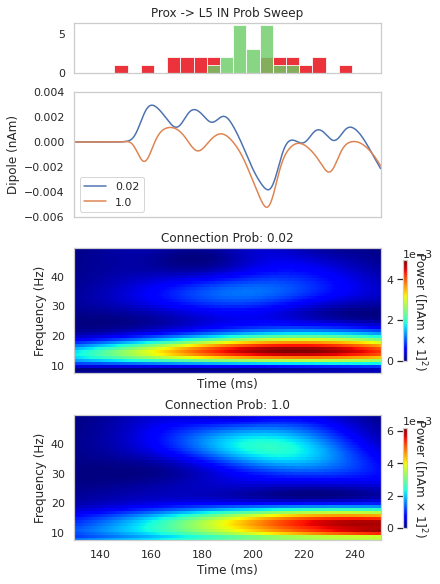

In [23]:
fig, axes = plt.subplots(4, 1, sharex=True, figsize=(6, 8), constrained_layout=True,
                         gridspec_kw={'height_ratios': [0.4, 1 , 1, 1]})
freqs = np.arange(8, 50)
times = dpl_L5IN_list[0].times
for plot_idx, (plt_dpl, prob) in enumerate(zip(dpl_L5IN_list, l5_prob_sweep)):
    dpl_smooth = plt_dpl.copy().smooth(10).data['agg']
    axes[1].plot(times, dpl_smooth, label=f'{prob}')
    axes[plot_idx+2].set_xlabel('')
    plt_dpl.copy().plot_tfr_morlet(freqs, ax=axes[plot_idx+2], show=False, colormap='jet')
    axes[plot_idx+2].set_title(f'Connection Prob: {prob}')

axes[0].set_title('Prox -> L5 IN Prob Sweep')
axes[1].legend()
axes[3].set_xlabel('Time (ms)')
axes[1].set_ylabel('Dipole (nAm)')
axes[1].set_ylim([-0.006, 0.004])


p_mask = np.array(net_L5IN_list[0].cell_response.spike_types[0]) == 'Proximal Drive'
d_mask = np.array(net_L5IN_list[0].cell_response.spike_types[0]) == 'Distal Drive'
p_times = np.array(net_L5IN_list[0].cell_response.spike_times[0])[p_mask]
d_times = np.array(net_L5IN_list[0].cell_response.spike_times[0])[d_mask]
bins = np.linspace(125, 275, 30)
axes[0].hist(p_times, color="#E8000B", label='Proximal', alpha=0.8, bins=bins)
axes[0].hist(d_times, color="#6ACC65", label='Distal', alpha=0.8, bins=bins)

for ax in axes:
    ax.grid(False)

plt.xlim([130,250])
plt.savefig('u19_page2_figures/law_input_prox_dist_l5inh_prob_sweep_spectrogram.png')


No handles with labels found to put in legend.


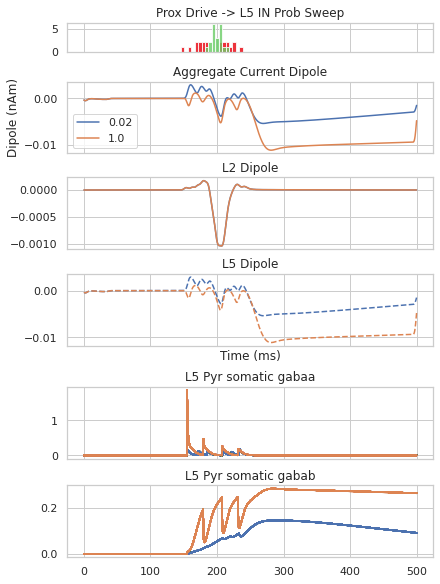

In [24]:
# L5 pyramidal neuron GABAa plot somatic currents
# Plot across the population
fig, axes = plt.subplots(6, 1, sharex=True, figsize=(6, 8), constrained_layout=True,
                         gridspec_kw={'height_ratios': [0.4, 1 , 1, 1, 1, 1]})

axes[0].set_title('Prox Drive -> L5 IN Prob Sweep')
axes[1].legend()
axes[3].set_xlabel('Time (ms)')
axes[1].set_ylabel('Dipole (nAm)')

p_mask = np.array(net_L5IN_list[0].cell_response.spike_types[0]) == 'Proximal Drive'
d_mask = np.array(net_L5IN_list[0].cell_response.spike_types[0]) == 'Distal Drive'
p_times = np.array(net_L5IN_list[0].cell_response.spike_times[0])[p_mask]
d_times = np.array(net_L5IN_list[0].cell_response.spike_times[0])[d_mask]
bins = np.linspace(125, 275, 30)
axes[0].hist(p_times, color="#E8000B", label='Proximal', alpha=0.8, bins=bins)
axes[0].hist(d_times, color="#6ACC65", label='Distal', alpha=0.8, bins=bins)
                         


l5pyr_gids = net.gid_ranges['L5_pyramidal']
for sim_idx, prob in enumerate(l5_prob_sweep):
    axes[1].plot(times, dpl_L5IN_list[sim_idx].copy().smooth(10).data['agg'], label=f'{prob}')

    axes[2].plot(times, dpl_L5IN_list[sim_idx].copy().smooth(10).data['L2'], 
                 label=f'{prob}; L2', color=f'C{sim_idx}')
    axes[3].plot(times, dpl_L5IN_list[sim_idx].copy().smooth(10).data['L5'], label=f'{prob}; L5', 
                 color=f'C{sim_idx}', linestyle='--')

    for gid in l5pyr_gids:
        isoma = net_L5IN_list[sim_idx].cell_response.isoma[0][gid]
        axes[4].plot(times, isoma['soma_gabaa'], color=f'C{sim_idx}', label=f'{prob}')
        axes[5].plot(times, isoma['soma_gabab'], color=f'C{sim_idx}', label=f'{prob}')

axes[1].legend()
axes[1].set_title('Aggregate Current Dipole')
axes[2].set_title('L2 Dipole')
axes[3].set_title('L5 Dipole')
axes[4].set_title('L5 Pyr somatic gabaa')
axes[5].set_title('L5 Pyr somatic gabab')

plt.savefig('u19_page2_figures/law_input_prox_dist_l5inh_prob_sweep_dipole_currents.png')

    

No handles with labels found to put in legend.


Text(0.5, 1.0, 'L5 Basket somatic gabaa')

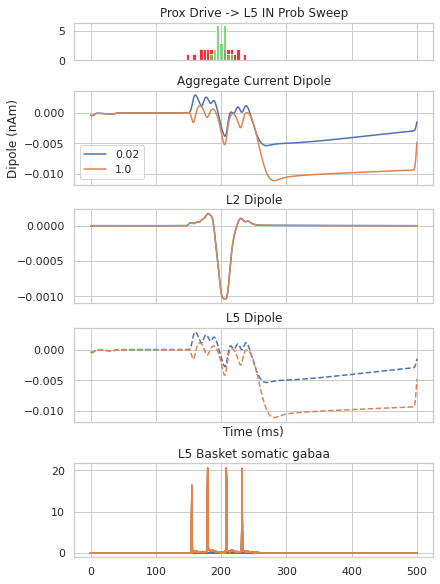

In [25]:
# L5 pyramidal neuron GABAa plot somatic currents
# Plot across the population
fig, axes = plt.subplots(5, 1, sharex=True, figsize=(6, 8), constrained_layout=True,
                         gridspec_kw={'height_ratios': [0.4 , 1, 1, 1, 1]})

axes[0].set_title('Prox Drive -> L5 IN Prob Sweep')
axes[1].legend()
axes[3].set_xlabel('Time (ms)')
axes[1].set_ylabel('Dipole (nAm)')

p_mask = np.array(net_L5IN_list[0].cell_response.spike_types[0]) == 'Proximal Drive'
d_mask = np.array(net_L5IN_list[0].cell_response.spike_types[0]) == 'Distal Drive'
p_times = np.array(net_L5IN_list[0].cell_response.spike_times[0])[p_mask]
d_times = np.array(net_L5IN_list[0].cell_response.spike_times[0])[d_mask]
bins = np.linspace(125, 275, 30)
axes[0].hist(p_times, color="#E8000B", label='Proximal', alpha=0.8, bins=bins)
axes[0].hist(d_times, color="#6ACC65", label='Distal', alpha=0.8, bins=bins)
                         


l5inh_gids = net.gid_ranges['L5_basket']
for sim_idx, prob in enumerate(l5_prob_sweep):
    axes[1].plot(times, dpl_L5IN_list[sim_idx].copy().smooth(10).data['agg'], label=f'{prob}')

    axes[2].plot(times, dpl_L5IN_list[sim_idx].copy().smooth(10).data['L2'], 
                 label=f'{prob}; L2', color=f'C{sim_idx}')
    axes[3].plot(times, dpl_L5IN_list[sim_idx].copy().smooth(10).data['L5'], label=f'{prob}; L5', 
                 color=f'C{sim_idx}', linestyle='--')

    for gid in l5inh_gids:
        isoma = net_L5IN_list[sim_idx].cell_response.isoma[0][gid]
        axes[4].plot(times, isoma['soma_gabaa'], color=f'C{sim_idx}', label=f'{prob}')
        #axes[5].plot(times, isoma['soma_gabab'], color=f'C{sim_idx}', label=f'{prob}')

axes[1].legend()
axes[1].set_title('Aggregate Current Dipole')
axes[2].set_title('L2 Dipole')
axes[3].set_title('L5 Dipole')
axes[4].set_title('L5 Basket somatic gabaa')
#axes[5].set_title('L5 Basket somatic gabab')

#plt.savefig('u19_page2_figures/law_input_prox_dist_l5inh_prob_sweep_dipole_currents.png')

    

In [30]:
net_orig = law_2021_model()

l2_prob_sweep = [0.02, 0.5]
dpl_L2IN_list = list()
net_L2IN_list = list()

for prob in l2_prob_sweep:

    net = net_orig.copy()
    #add_law_beta_drives(net, beta_start=200.0, l2inh_prob=prob)
    add_law_beta_drives(net, beta_start=200.0, l2inh_strength=100, l2inh_prob=prob)

    with MPIBackend(n_procs=8):
        dpl = simulate_dipole(net, tstop=500, dt=0.05, record_isoma=True)[0]

    dpl_L2IN_list.append(dpl)
    net_L2IN_list.append(net)


MPI will run over 8 processes
Running 1 trials...
numprocs=8
Loading custom mechanism files from /home/ntolley/Jones_Lab/hnn-core/hnn_core/mod/x86_64/.libs/libnrnmech.so
Building the NEURON model
Loading custom mechanism files from /home/ntolley/Jones_Lab/hnn-core/hnn_core/mod/x86_64/.libs/libnrnmech.so
Loading custom mechanism files from /home/ntolley/Jones_Lab/hnn-core/hnn_core/mod/x86_64/.libs/libnrnmech.so
Loading custom mechanism files from /home/ntolley/Jones_Lab/hnn-core/hnn_core/mod/x86_64/.libs/libnrnmech.so
Loading custom mechanism files from /home/ntolley/Jones_Lab/hnn-core/hnn_core/mod/x86_64/.libs/libnrnmech.so
Loading custom mechanism files from /home/ntolley/Jones_Lab/hnn-core/hnn_core/mod/x86_64/.libs/libnrnmech.so
Loading custom mechanism files from /home/ntolley/Jones_Lab/hnn-core/hnn_core/mod/x86_64/.libs/libnrnmech.so
Loading custom mechanism files from /home/ntolley/Jones_Lab/hnn-core/hnn_core/mod/x86_64/.libs/libnrnmech.so
[Done]
running trial 1 on 8 cores
Simulat

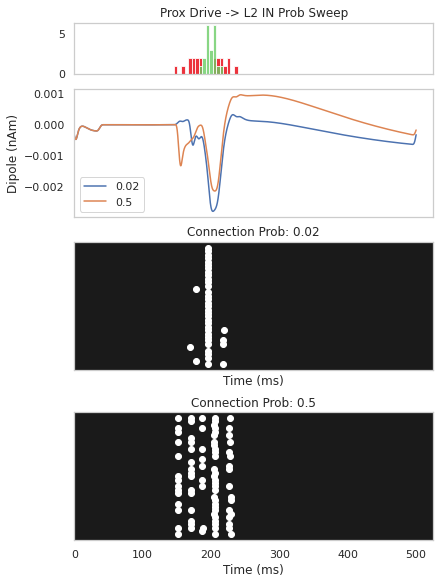

In [34]:
fig, axes = plt.subplots(4, 1, sharex=True, figsize=(6, 8), constrained_layout=True,
                         gridspec_kw={'height_ratios': [0.4, 1 , 1, 1]})
freqs = np.arange(8, 50)
times = dpl_L2IN_list[0].times
for plot_idx, (plt_dpl, prob, net) in enumerate(zip(dpl_L2IN_list, l2_prob_sweep, net_L2IN_list)):
    dpl_smooth = plt_dpl.copy().smooth(10).data['agg']
    axes[1].plot(times, dpl_smooth, label=f'{prob}')
    axes[plot_idx+2].set_title(f'Connection Prob: {prob}')
    net.copy().cell_response.plot_spikes_raster(ax=axes[plot_idx+2], show=False)
    axes[plot_idx].set_xlabel('')


axes[0].set_title('Prox Drive -> L2 IN Prob Sweep')
axes[3].set_xlabel('Time (ms)')
axes[1].set_ylabel('Dipole (nAm)')
axes[1].legend()

p_mask = np.array(net_L5IN_list[0].cell_response.spike_types[0]) == 'Proximal Drive'
d_mask = np.array(net_L5IN_list[0].cell_response.spike_types[0]) == 'Distal Drive'
p_times = np.array(net_L5IN_list[0].cell_response.spike_times[0])[p_mask]
d_times = np.array(net_L5IN_list[0].cell_response.spike_times[0])[d_mask]
bins = np.linspace(125, 275, 30)
axes[0].hist(p_times, color="#E8000B", label='Proximal', alpha=0.8, bins=bins)
axes[0].hist(d_times, color="#6ACC65", label='Distal', alpha=0.8, bins=bins)
axes[2].get_legend().remove()
axes[3].get_legend().remove()
#plt.xlim([130,250])

for ax in axes:
    ax.grid(False)

plt.savefig('u19_page2_figures/law_input_prox_dist_l2inh_prob_sweep_spikes.png')


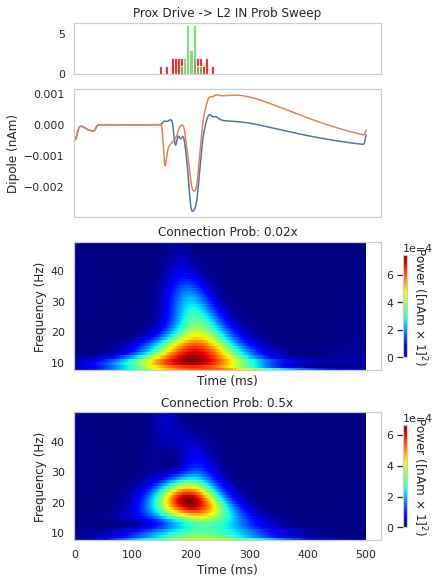

In [35]:
fig, axes = plt.subplots(4, 1, sharex=True, figsize=(6, 8), constrained_layout=True,
                         gridspec_kw={'height_ratios': [0.4, 1 , 1, 1]})
freqs = np.arange(8, 50)
times = dpl_L2IN_list[0].times
for plot_idx, (plt_dpl, scale) in enumerate(zip(dpl_L2IN_list, l2_prob_sweep)):
    dpl_smooth = plt_dpl.copy().smooth(10).data['agg']
    axes[1].plot(times, dpl_smooth, label=f'{scale}x')
    axes[plot_idx].set_xlabel('')
    plt_dpl.copy().plot_tfr_morlet(freqs, ax=axes[plot_idx+2], show=False, colormap='jet')
    axes[plot_idx+2].set_title(f'Connection Prob: {scale}x')

p_mask = np.array(net_L5IN_list[0].cell_response.spike_types[0]) == 'Proximal Drive'
d_mask = np.array(net_L5IN_list[0].cell_response.spike_types[0]) == 'Distal Drive'
p_times = np.array(net_L5IN_list[0].cell_response.spike_times[0])[p_mask]
d_times = np.array(net_L5IN_list[0].cell_response.spike_times[0])[d_mask]
bins = np.linspace(125, 275, 30)
axes[0].hist(p_times, color="#E8000B", label='Proximal', alpha=0.8, bins=bins)
axes[0].hist(d_times, color="#6ACC65", label='Distal', alpha=0.8, bins=bins)

axes[0].set_title('Prox Drive -> L2 IN Prob Sweep')
axes[3].set_xlabel('Time (ms)')
axes[1].set_ylabel('Dipole (nAm)')
#plt.xlim([130,250])
for ax in axes:
    ax.grid(False)

plt.savefig('u19_page2_figures/law_input_prox_dist_l2inh_prob_sweep_spectrogram.png')


No handles with labels found to put in legend.


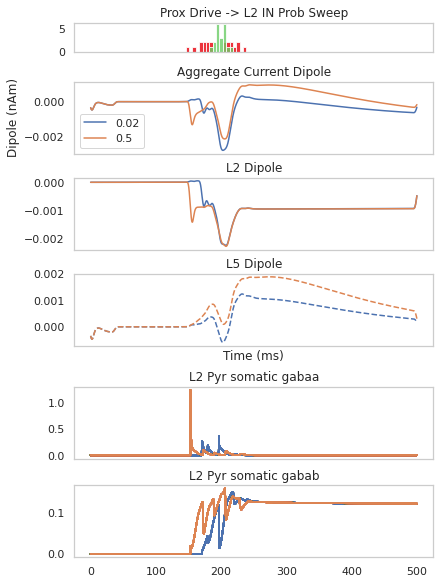

In [37]:
# L5 pyramidal neuron GABAa plot somatic currents
# Plot across the population
fig, axes = plt.subplots(6, 1, sharex=True, figsize=(6, 8), constrained_layout=True,
                         gridspec_kw={'height_ratios': [0.4, 1 , 1, 1, 1, 1]})

axes[0].set_title('Prox Drive -> L2 IN Prob Sweep')
axes[1].legend()
axes[3].set_xlabel('Time (ms)')
axes[1].set_ylabel('Dipole (nAm)')

p_mask = np.array(net_L2IN_list[0].cell_response.spike_types[0]) == 'Proximal Drive'
d_mask = np.array(net_L2IN_list[0].cell_response.spike_types[0]) == 'Distal Drive'
p_times = np.array(net_L2IN_list[0].cell_response.spike_times[0])[p_mask]
d_times = np.array(net_L2IN_list[0].cell_response.spike_times[0])[d_mask]
bins = np.linspace(125, 275, 30)
axes[0].hist(p_times, color="#E8000B", label='Proximal', alpha=0.8, bins=bins)
axes[0].hist(d_times, color="#6ACC65", label='Distal', alpha=0.8, bins=bins)
                         


l5pyr_gids = net.gid_ranges['L2_pyramidal']
for sim_idx, prob in enumerate(l2_prob_sweep):
    axes[1].plot(times, dpl_L2IN_list[sim_idx].copy().smooth(10).data['agg'], label=f'{prob}')

    axes[2].plot(times, dpl_L2IN_list[sim_idx].copy().smooth(10).data['L2'], 
                 label=f'{prob}; L2', color=f'C{sim_idx}')
    axes[3].plot(times, dpl_L2IN_list[sim_idx].copy().smooth(10).data['L5'], label=f'{prob}; L5', 
                 color=f'C{sim_idx}', linestyle='--')

    for gid in l5pyr_gids:
        isoma = net_L2IN_list[sim_idx].cell_response.isoma[0][gid]
        axes[4].plot(times, isoma['soma_gabaa'], color=f'C{sim_idx}', label=f'{prob}')
        axes[5].plot(times, isoma['soma_gabab'], color=f'C{sim_idx}', label=f'{prob}')

axes[1].legend()
axes[1].set_title('Aggregate Current Dipole')
axes[2].set_title('L2 Dipole')
axes[3].set_title('L5 Dipole')
axes[4].set_title('L2 Pyr somatic gabaa')
axes[5].set_title('L2 Pyr somatic gabab')
for ax in axes:
    ax.grid(False)
    
plt.savefig('u19_page2_figures/law_input_prox_dist_l2inh_prob_sweep_dipole_currents.png')

    
    